In [1]:
import sys
sys.path.insert(0,'/home/leo/Documents/cosmic_ray_generator/')
import functions
from rejection_sampler import generator
import numpy
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize


In [31]:
gen = generator(times=True,with_angles=True,detector_area=900)

In [40]:
a=gen.create(200000)

/home/leo/Documents/cosmic_ray_generator/functions.py:13: RuntimeWarning: invalid value encountered in power
  return ((lambda_N*np.cos(theta))/X_0)**p_1 * ((E_mu)/(E_mu + alphax0/np.cos(theta)))**(p_1 + gamma + 1) * spec.gamma(p_1 + 1)
/home/leo/Documents/cosmic_ray_generator/rejection_sampler.py:134: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  scaling=64.12300/integrate.quad(functions.integrated_fast, a=self.llim, b=self.ulim)[0]


In [41]:
a

array([[1.93337685e+00, 4.32183077e-01, 1.57177585e-02],
       [2.25695605e+00, 6.51135887e-01, 2.48465327e-01],
       [3.81931272e+00, 3.23317217e-01, 5.08498719e-01],
       ...,
       [1.35575496e+00, 2.16575663e-01, 2.56310962e+04],
       [1.13029705e-01, 3.53589110e-01, 2.56311319e+04],
       [3.09930410e-01, 6.19407769e-02, 2.56315641e+04]])

In [33]:
numpy.mean([a[i][0] for i in range(len(a))])

6.375407854151985

In [42]:
def binn(data,bins):
    b=[]
    for i in range(len(bins)-1):
        a=[]
        for j in data:
            if j<=bins[i+1] and j>=bins[i]:
                a.append(j)
        b.append(a)
    return b

In [56]:
b=numpy.histogram([numpy.log10(a[i][0]) for i in range(len(a)) if a[i][1]<0.09966],bins=[0.1*i for i in range(60)])

In [43]:
bins=[-2+0.1*i for i in range(60)]
binned=binn([numpy.log10(a[i][0]) for i in range(len(a))],bins)
d=binned

In [7]:
c=pd.DataFrame({'freq':[len(d[i]) for i in range(len(d))],'p_average':[numpy.log10(numpy.mean([10**d[i][j] for j in range(len(d[i]))])) for i in range(len(d))],\
    'p_range':[10**bins[i+1]-10**bins[i] for i in range(len(bins)-1)]})
c=c.drop([i for i in range(len(c['freq'])) if c['freq'][i]<5])

/home/leo/miniconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/leo/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [44]:
vertical_c=[a[i][0] for i in range(len(a)) if a[i][1]<numpy.radians(1)]
bins=[-3+0.1*i for i in range(60)]
d=binn([numpy.log10(vertical_c[i]) for i in range(len(vertical_c))],bins)
c=pd.DataFrame({'freq':[len(d[i]) for i in range(len(d))],'p_average':[numpy.log10(numpy.mean([10**d[i][j] for j in range(len(d[i]))])) for i in range(len(d))],\
    'p_range':[10**bins[i+1]-10**bins[i] for i in range(len(bins)-1)]})
c=c.drop([i for i in range(len(c['freq'])) if c['freq'][i]<1])

/home/leo/miniconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/leo/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [36]:
numpy.sum([len(d[i]) for i in range(len(d))])

404

In [42]:
angle_c=[a[i][1] for i in range(len(a)) if a[i][0]>1000]
bins=[numpy.deg2rad(5*i) for i in range(0,18)]
d=binn(angle_c, bins)
c=pd.DataFrame({'freq':[len(d[i]) for i in range(len(d))],'zenith angle':[numpy.rad2deg((bins[i]+bins[i+1])/2) for i in range(17)]})

In [46]:
c

,freq,p_average,p_range
13,1,-1.640830,0.005166
15,2,-1.441402,0.008188
17,1,-1.276355,0.012977
18,5,-1.144922,0.016337
19,7,-1.037423,0.020567
20,13,-0.938063,0.025893
21,12,-0.850119,0.032597
22,25,-0.745657,0.041037
23,45,-0.642409,0.051662
24,58,-0.549522,0.065039


In [9]:
c['diff_int']=c['freq']/c['p_range']
c=c.drop([i for i in range(len(c['freq'])) if c['freq'][i]<=1])
c

KeyError: 0

In [50]:
c['diff_int']=c['freq']/(c['p_range']*(2.56*10**4*4*numpy.pi*(1-numpy.cos(numpy.deg2rad(1)))))
#c['p_average']=10**c['p_average']
c

,freq,p_average,p_range,diff_int
13,1,0.022865,0.005166,3.950588
15,2,0.036191,0.008188,4.985305
17,1,0.052923,0.012977,1.572758
18,5,0.071627,0.016337,6.246429
19,7,0.091744,0.020567,6.946401
20,13,0.115329,0.025893,10.247198
21,12,0.141215,0.032597,7.513513
22,25,0.179615,0.041037,12.433740
23,45,0.227820,0.051662,17.777648
24,58,0.282149,0.065039,18.200771


In [9]:
numpy.sum(c['diff_int'])*10**4

367.7164885855479

In [15]:
numpy.sum(c['freq'])/(0.03*10**4*7.42*10**3)

0.00019451931716082659

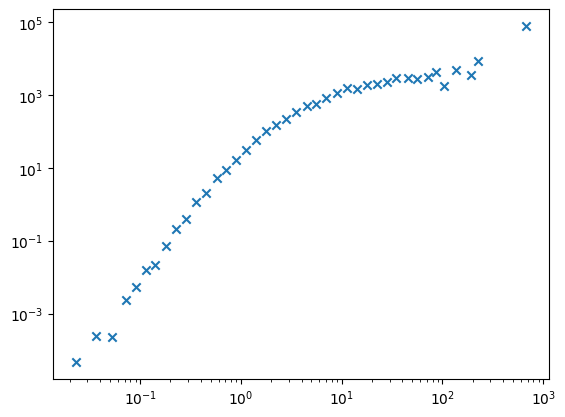

In [51]:
plt.scatter(c['p_average'],c['diff_int']*(c['p_average'])**3, marker='x')
plt.yscale('log')
plt.xscale('log')
plt.show()

In [25]:
1/(2*numpy.tan(numpy.deg2rad(1)))

28.644980815379714

In [21]:
with open('gen_data_angle_actual.npy','wb') as f:
    numpy.save(f,c)
c

,freq,zenith angle
0,232,2.5
1,247,7.5
2,210,12.5
3,250,17.5
4,227,22.5
5,237,27.5
6,250,32.5
7,213,37.5
8,226,42.5
9,219,47.5


In [48]:
def exp(x, params):
    a=params
    return a/(numpy.cos(numpy.deg2rad(x)))
def res(params,x,y):
    return y-exp(x,params)
def fit(data):
    popt=optimize.leastsq(res,x0=numpy.array([100]),args=(data[0],data[1]))
    print(popt)
    return(popt[0])

(array([404.01741081]), 3)


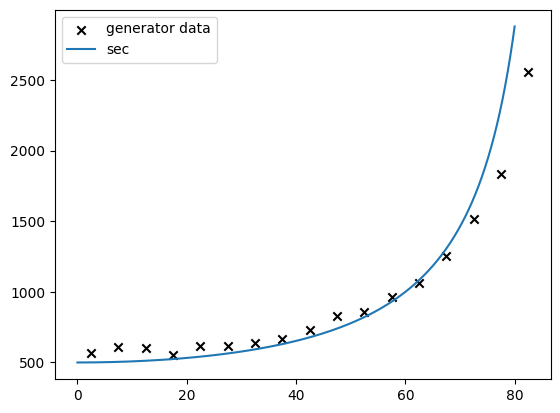

In [51]:
x=numpy.linspace(0,80,10000)
plt.scatter(c['zenith angle'],c['freq'], marker='x', label='generator data', color='black')
# p=fit([c['zenith angle'],c['freq']])
# p1=p[0]
# p2=p[1]
# y=p1*numpy.cos(numpy.deg2rad(x))**p2
# plt.plot(x, y, color='m', label='cos^2.19')
# plt.plot(x,p1*numpy.cos(numpy.deg2rad(x))**2, label='cos^2', color='r')
p=fit([c['zenith angle'],c['freq']])
plt.plot(x,500/(numpy.cos(numpy.deg2rad(x))), label='sec')
#plt.plot(x, 1/numpy.cos(numpy.deg2rad(x)))
plt.legend()

In [55]:
min([a[i][0] for i in range(len(a))])

0.005347106226905041

In [45]:
p[0]

20813.090457043243